# 승촌보 데이터 분석(모델 찾기) 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

## matplotlib 한글 설정  
* 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원. 

In [3]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 수질 데이터 불러오기

데이터 저장소

In [4]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

승촌보 데이터 불러오기. `'측정일/월'` 특성은 date time으로 파싱.

In [5]:
scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

시간 특성을 '년.월.일 시' 형식으로 변환하는 함수

In [6]:
# 연도별로 별도로 작동한다.

def time2datetime(df_yearly_dict, feature):
    for year in list(df_yearly_dict.keys()):
        df_yearly_dict[year][feature] = df_yearly_dict[year][feature].apply(lambda x : x.strftime('%Y-%m-%d %H'))
    
    return df_yearly_dict

'측정일/월' 특성을 '년-월-일 시'형식으로 변경한다.

In [7]:
scb_yearly = time2datetime(scb_yearly, '측정일/월')

2012년도 데이터를 제외한 모든 데이터 통합 함수

In [8]:
# 반환값은 데이터프레임

def concat_yearly_df(df_yearly_dict):
    df_concat = pd.DataFrame()

    for year in list(df_yearly_dict.keys())[1:]:
        df_concat = pd.concat([df_concat, df_yearly_dict[year]])

    return df_concat

### 연도별 수질 데이터 통합

In [9]:
# 2013년도부터 통합
scb_yearly_df13 = concat_yearly_df(scb_yearly)

# 인덱스 재설정
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

## 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

In [10]:
scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

시간 특성을 '년-월-일 시'형식으로 변경한다.

In [11]:
scb_flow_yearly = time2datetime(scb_flow_yearly, '시간')

**10분 단위를 1시간 단위로 변경**  

시간별 평균값을 활용한다.

In [12]:
scb_flow_yearly_hour = {}

# groupby의 as_index=False 옵션 사용. 인덱스 자동 재설정됨.
for year in list(scb_flow_yearly.keys()):
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간', as_index=False).mean()

### 연도별 유량 데이터 통합

In [13]:
# 2013년부터 통합
scb_flow_yearly_hour_df = concat_yearly_df(scb_flow_yearly_hour)

# 인덱스 재설정
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

## 수질/유량 데이터 합병  

수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.

In [14]:
# 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

# `pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

# 유량 데이터 2022년도 데이터를 더 많이 포함하기에 삭제 필요.
scb_data = scb_data[:len(scb_yearly_df13)]

# 유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 데이터셋 전처리

### 특성 선택

훈련에 사용하지 않을 특성 삭제

In [15]:
scb_data.drop(['수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)'], axis=1, inplace=True)

In [16]:
scb_data.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

### 클로로필 정규화

회귀 모델을 적용하기 전에 클로로필 값이 정규 분포인지 확인. 왼쪽으로 치우친 형태임.

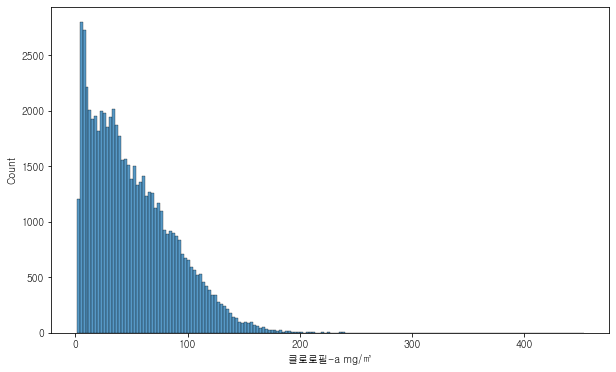

In [17]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포에 가까워짐 

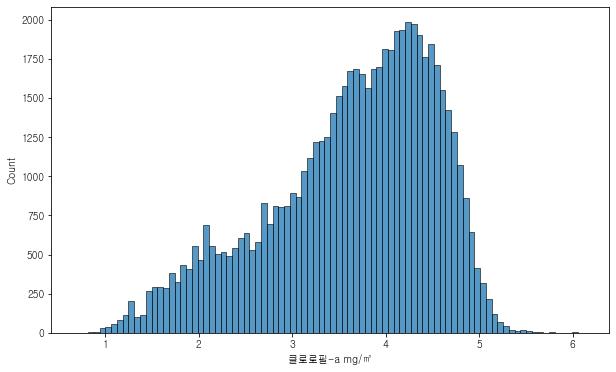

In [18]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환 뒤 `scb_data`에 추가

In [19]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

In [20]:
scb_data.head(3)

,시간,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
0,2013-01-01 00,용봉,3.9,374.0,2.5,NaN,NaN,7.2,7.5,19.748333,2.104134
1,2013-01-01 01,용봉,3.9,375.0,2.5,NaN,NaN,6.9,7.5,19.706667,2.066863
2,2013-01-01 02,용봉,4.0,374.0,2.5,NaN,NaN,6.8,7.5,19.723333,2.054124


In [21]:
scb_df = scb_data.copy()

### 결측치 보간법

시간 특성을 date time 자료형으로 변환

In [22]:
scb_df['시간'] = scb_df['시간'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))

결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.      
예) 결측치가 36개인 구간이 있다면 처음-12개와 25-36개만 결측치 대체.  

In [23]:
scb_df = scb_df.copy().set_index('시간').interpolate(method='time', limit = 12, limit_direction='both')

결측치 제거

In [24]:
scb_df.dropna(inplace=True)

In [25]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59058 entries, 2013-03-29 04:00:00 to 2022-05-23 23:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정소명         59058 non-null  object 
 1   수온 ℃         59058 non-null  float64
 2   전기전도도 μS/cm  59058 non-null  float64
 3   총유기탄소 mg/L   59058 non-null  float64
 4   총질소 mg/L     59058 non-null  float64
 5   총인 mg/L      59058 non-null  float64
 6   클로로필-a mg/㎥  59058 non-null  float64
 7   상류수위(EL.m)   59058 non-null  float64
 8   방류량(㎥/s)     59058 non-null  float64
 9   log_Chl-a    59058 non-null  float64
dtypes: float64(9), object(1)
memory usage: 5.0+ MB


## 상류수위가 10을 넘는 이상치 자료 2개 삭제

In [26]:
scb_df[scb_df['상류수위(EL.m)'] > 10]

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
시간,,,,,,,,,,
2020-05-15 17:00:00,용봉,20.4,326.0,5.0,3.082,0.128,31.8,31.233333,69.661667,3.490429
2020-05-18 18:00:00,용봉,21.8,294.0,5.1,2.345,0.182,17.6,31.241667,55.898333,2.923162


In [27]:
len(scb_df)

59058

In [28]:
len(scb_df[scb_df['상류수위(EL.m)'] < 10])

59056

In [29]:
scb_df = scb_df[scb_df['상류수위(EL.m)'] < 10]

## 훈련 특성과 타깃  

log_Chl-a 은 타깃. 측정소명과 클로로필을 제외한 특성을 이용.

In [30]:
remove_feature = ['측정소명', '클로로필-a mg/㎥', 'log_Chl-a']

In [31]:
col = list(scb_df.columns)

for i in remove_feature:
    col.remove(i)

In [32]:
print(col)

['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)']


## 특성의 기초통계량

In [33]:
scb_df.describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
count,59056.000000,59056.000000,59056.000000,59056.000000,59056.000000,59056.000000,59056.000000,59056.000000,59056.000000
mean,17.960720,339.611118,4.364166,5.397617,0.119299,50.348623,6.846137,26.510776,3.614575
std,8.025408,88.198118,1.026317,2.001516,0.064105,37.236173,0.864409,62.511053,0.893559
min,1.800000,92.000000,1.600000,0.706000,0.003000,1.000000,4.038333,0.000000,0.693147
25%,10.000000,277.000000,3.600000,3.816000,0.074000,20.900000,5.980000,11.400000,3.081910
50%,18.200000,339.000000,4.274167,5.157000,0.106000,42.500000,7.490000,15.235833,3.772761
75%,25.100000,411.000000,5.000000,6.726000,0.150000,72.300000,7.530000,25.947083,4.293195
max,36.100000,730.000000,19.300000,12.357000,0.745000,453.500000,8.071667,2710.731667,6.119198


## 모델 훈련

### 평가 : MSE, RMSE, R-square

In [34]:
def get_scores(y_test, pred):
    print('MSE: ', mean_squared_error(np.expm1(y_test), np.expm1(pred)))
    print('MSE log변환: ', mean_squared_error(y_test, pred))
    print('RMSE: ', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred))))
    print('RMSE log변환: ', np.sqrt(mean_squared_error(y_test, pred)))
    print('R-square: ', estimator.score(X_test, y_test) )

### ElasticNet

In [35]:
scaler = StandardScaler()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 스케일링 된 결과 값으로 본래 값을 구할 수도 있다.
# X_origin = scaler.inverse_transform(X_train_scaled)

en_reg = ElasticNet(random_state=42)

parameters = {'alpha':[0.001, 0.01, 0.1, 0.5, 1, 10, 100], 'l1_ratio':[0.1, 0.2, 0.5, 0.7, 0.8, 0.9]}

In [37]:
en_grid = GridSearchCV(en_reg, param_grid=parameters, scoring = 'r2', cv=3, verbose=5)

In [38]:
en_grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV 1/3] END .........alpha=0.001, l1_ratio=0.1;, score=0.337 total time=   0.0s
[CV 2/3] END .........alpha=0.001, l1_ratio=0.1;, score=0.354 total time=   0.0s
[CV 3/3] END .........alpha=0.001, l1_ratio=0.1;, score=0.341 total time=   0.0s
[CV 1/3] END .........alpha=0.001, l1_ratio=0.2;, score=0.337 total time=   0.0s
[CV 2/3] END .........alpha=0.001, l1_ratio=0.2;, score=0.354 total time=   0.0s
[CV 3/3] END .........alpha=0.001, l1_ratio=0.2;, score=0.341 total time=   0.0s
[CV 1/3] END .........alpha=0.001, l1_ratio=0.5;, score=0.337 total time=   0.0s
[CV 2/3] END .........alpha=0.001, l1_ratio=0.5;, score=0.354 total time=   0.0s
[CV 3/3] END .........alpha=0.001, l1_ratio=0.5;, score=0.341 total time=   0.0s
[CV 1/3] END .........alpha=0.001, l1_ratio=0.7;, score=0.337 total time=   0.0s
[CV 2/3] END .........alpha=0.001, l1_ratio=0.7;, score=0.354 total time=   0.0s
[CV 3/3] END .........alpha=0.001, l1_ratio=0.7

[CV 3/3] END ..........alpha=100, l1_ratio=0.1;, score=-0.000 total time=   0.0s
[CV 1/3] END ..........alpha=100, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 2/3] END ..........alpha=100, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 3/3] END ..........alpha=100, l1_ratio=0.2;, score=-0.000 total time=   0.0s
[CV 1/3] END ..........alpha=100, l1_ratio=0.5;, score=-0.000 total time=   0.0s
[CV 2/3] END ..........alpha=100, l1_ratio=0.5;, score=-0.000 total time=   0.0s
[CV 3/3] END ..........alpha=100, l1_ratio=0.5;, score=-0.000 total time=   0.0s
[CV 1/3] END ..........alpha=100, l1_ratio=0.7;, score=-0.000 total time=   0.0s
[CV 2/3] END ..........alpha=100, l1_ratio=0.7;, score=-0.000 total time=   0.0s
[CV 3/3] END ..........alpha=100, l1_ratio=0.7;, score=-0.000 total time=   0.0s
[CV 1/3] END ..........alpha=100, l1_ratio=0.8;, score=-0.000 total time=   0.0s
[CV 2/3] END ..........alpha=100, l1_ratio=0.8;, score=-0.000 total time=   0.0s
[CV 3/3] END ..........alpha

GridSearchCV(cv=3, estimator=ElasticNet(random_state=42),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100],
                         'l1_ratio': [0.1, 0.2, 0.5, 0.7, 0.8, 0.9]},
             scoring='r2', verbose=5)

In [39]:
scores_df = pd.DataFrame(en_grid.cv_results_)

In [40]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
0,"{'alpha': 0.001, 'l1_ratio': 0.1}",0.343906,1
1,"{'alpha': 0.001, 'l1_ratio': 0.2}",0.343906,2
2,"{'alpha': 0.001, 'l1_ratio': 0.5}",0.343904,3
3,"{'alpha': 0.001, 'l1_ratio': 0.7}",0.343902,4
4,"{'alpha': 0.001, 'l1_ratio': 0.8}",0.343901,5


In [41]:
en_grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.1}

In [42]:
estimator = en_grid.best_estimator_

**베스트모델 저장**

In [43]:
joblib.dump(estimator, "승촌보_en_전체0110.pkl")

['승촌보_en_전체0110.pkl']

**베스트모델 다시 불러오기**

In [44]:
estimator = joblib.load("승촌보_en_전체0110.pkl")

In [45]:
pred = estimator.predict(X_test_scaled)

In [46]:
coeff = pd.Series(data=estimator.coef_, index=X_test.columns)
coeff = coeff.sort_values(ascending=False)
coeff

수온 ℃           0.401275
전기전도도 μS/cm    0.317942
총질소 mg/L       0.154264
총유기탄소 mg/L     0.117852
방류량(㎥/s)      -0.095849
총인 mg/L       -0.143171
상류수위(EL.m)    -0.184941
dtype: float64

In [47]:
estimator.score(X_test_scaled, y_test) # R square

0.32887378080773755

In [48]:
print('RMSE: ', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred))))
print('RMSE log변환: ', np.sqrt(mean_squared_error(y_test, pred)))

RMSE:  36.47479479912325
RMSE log변환:  0.7252039782707583


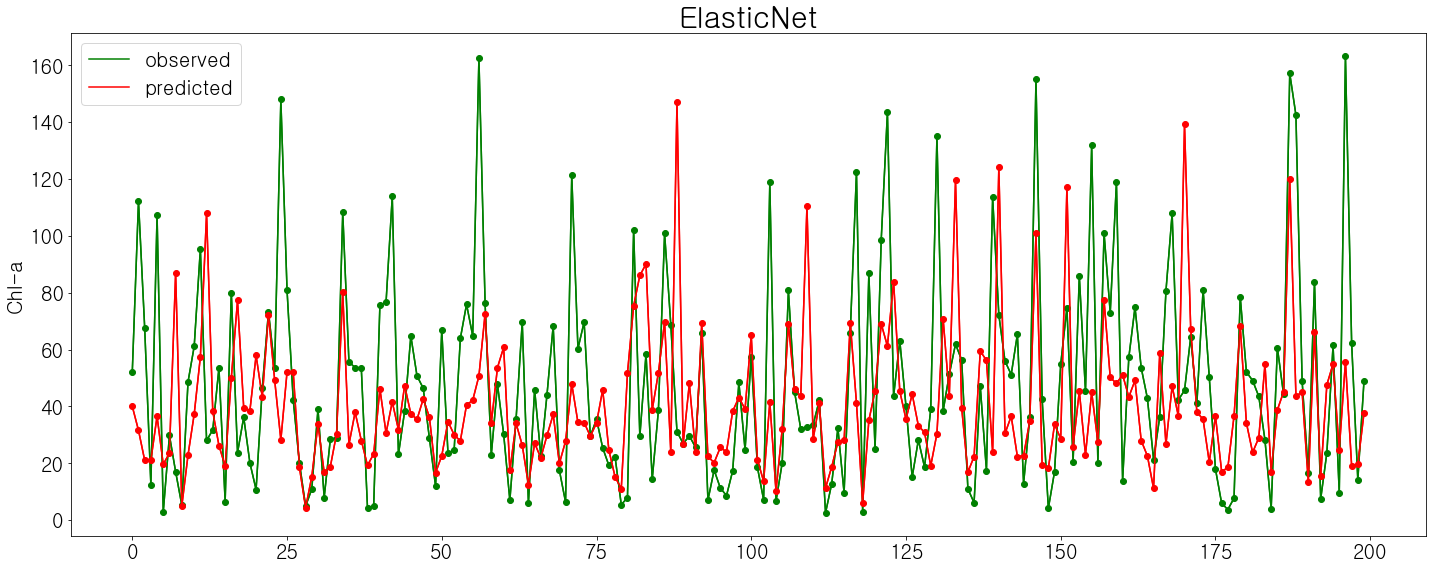

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(range(200), np.expm1(y_test)[:200], color='green')
plt.plot(range(200), np.expm1(pred)[:200], color='red')
plt.plot(range(200), np.expm1(y_test)[:200], marker='o', color='green')
plt.plot(range(200), np.expm1(pred)[:200], marker='o', color='red')
plt.legend(['observed', 'predicted'], fontsize=20)
plt.ylabel('Chl-a', fontsize=20)
plt.title('ElasticNet', fontsize='30')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('scb_elasticNet.png', facecolor='white')# dpi = 1000
plt.show()

### DecisionTree

In [60]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
dt_reg = DecisionTreeRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15, 20, 25, 30, 50], 'min_samples_leaf':[1, 4, 8, 12, 16]}

In [61]:
dt_grid = GridSearchCV(dt_reg, param_grid=parameters, cv=3, verbose=5)

In [62]:
dt_grid.fit(X_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV 1/3] END ...max_depth=5, min_samples_leaf=1;, score=0.557 total time=   0.0s
[CV 2/3] END ...max_depth=5, min_samples_leaf=1;, score=0.582 total time=   0.0s
[CV 3/3] END ...max_depth=5, min_samples_leaf=1;, score=0.562 total time=   0.0s
[CV 1/3] END ...max_depth=5, min_samples_leaf=4;, score=0.557 total time=   0.0s
[CV 2/3] END ...max_depth=5, min_samples_leaf=4;, score=0.582 total time=   0.0s
[CV 3/3] END ...max_depth=5, min_samples_leaf=4;, score=0.562 total time=   0.0s
[CV 1/3] END ...max_depth=5, min_samples_leaf=8;, score=0.557 total time=   0.0s
[CV 2/3] END ...max_depth=5, min_samples_leaf=8;, score=0.582 total time=   0.0s
[CV 3/3] END ...max_depth=5, min_samples_leaf=8;, score=0.562 total time=   0.0s
[CV 1/3] END ..max_depth=5, min_samples_leaf=12;, score=0.555 total time=   0.0s
[CV 2/3] END ..max_depth=5, min_samples_leaf=12;, score=0.582 total time=   0.0s
[CV 3/3] END ..max_depth=5, min_samples_leaf=12

[CV 3/3] END .max_depth=50, min_samples_leaf=12;, score=0.827 total time=   0.0s
[CV 1/3] END .max_depth=50, min_samples_leaf=16;, score=0.814 total time=   0.0s
[CV 2/3] END .max_depth=50, min_samples_leaf=16;, score=0.819 total time=   0.0s
[CV 3/3] END .max_depth=50, min_samples_leaf=16;, score=0.813 total time=   0.0s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 50],
                         'min_samples_leaf': [1, 4, 8, 12, 16]},
             verbose=5)

In [63]:
scores_df = pd.DataFrame(dt_grid.cv_results_)

In [64]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
21,"{'max_depth': 25, 'min_samples_leaf': 4}",0.856641,1
31,"{'max_depth': 50, 'min_samples_leaf': 4}",0.856422,2
26,"{'max_depth': 30, 'min_samples_leaf': 4}",0.856351,3
16,"{'max_depth': 20, 'min_samples_leaf': 4}",0.855487,4
20,"{'max_depth': 25, 'min_samples_leaf': 1}",0.853650,5


In [65]:
dt_grid.best_params_

{'max_depth': 25, 'min_samples_leaf': 4}

In [66]:
estimator = dt_grid.best_estimator_

**베스트모델 저장**

In [67]:
joblib.dump(estimator, "승촌보_dt_전체0110.pkl")

['승촌보_dt_전체0110.pkl']

**베스트모델 다시 불러오기**

In [68]:
estimator = joblib.load("승촌보_dt_전체0110.pkl")

In [69]:
pred = estimator.predict(X_test)

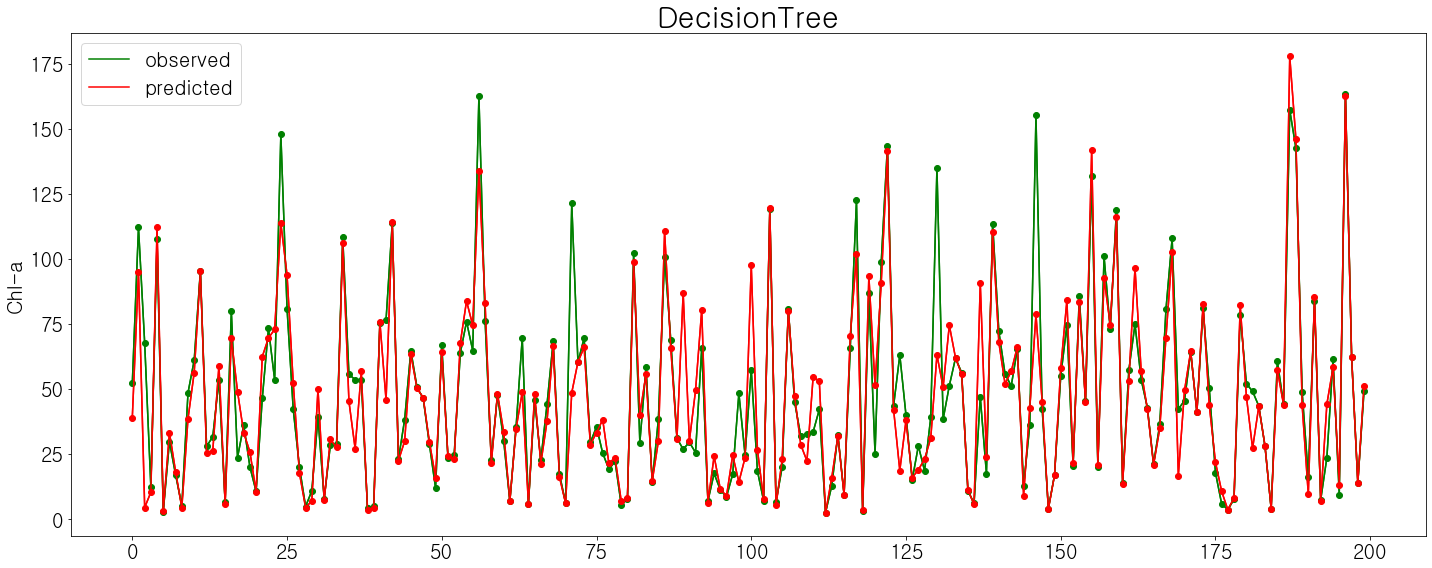

In [70]:
plt.figure(figsize=(20, 8))
plt.plot(range(200), np.expm1(y_test)[:200], color='green')
plt.plot(range(200), np.expm1(pred)[:200], color='red')
plt.plot(range(200), np.expm1(y_test)[:200], marker='o', color='green')
plt.plot(range(200), np.expm1(pred)[:200], marker='o', color='red')
plt.legend(['observed', 'predicted'], fontsize=20)
plt.ylabel('Chl-a', fontsize=20)
plt.title('DecisionTree', fontsize='30')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('scb_decisionTree.png', facecolor='white')
plt.show()

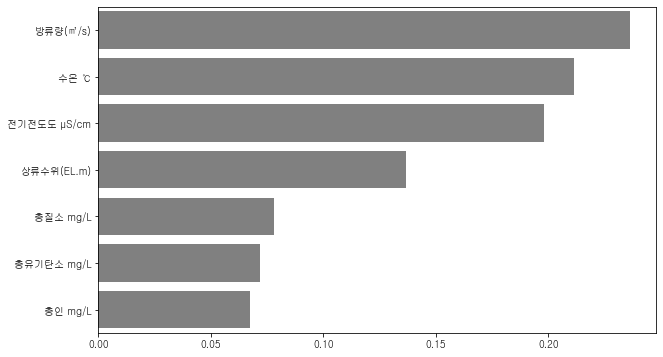

In [71]:
feature_series_dt = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_dt = feature_series_dt.sort_values(ascending = False)
sns.barplot(x = feature_series_dt[:10], y = feature_series_dt.index[:10], color = 'gray')
plt.show()

In [72]:
feature_series_dt[:10]

방류량(㎥/s)       0.236059
수온 ℃           0.211421
전기전도도 μS/cm    0.197957
상류수위(EL.m)     0.136878
총질소 mg/L       0.078163
총유기탄소 mg/L     0.072065
총인 mg/L        0.067456
dtype: float64

In [73]:
get_scores(y_test, pred)

MSE:  249.958721954144
MSE log변환:  0.08991443999698734
RMSE:  15.810082920533466
RMSE log변환:  0.2998573660875906
R-square:  0.8852604099188922


### RandomForest

In [74]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15, 17, 20, 22], 'min_samples_leaf':[1, 4, 8, 12, 16]}

In [75]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [76]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 17, 20, 22],
                         'min_samples_leaf': [1, 4, 8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [77]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [78]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
51,"{'max_depth': 22, 'min_samples_leaf': 1, 'n_es...",0.934955,1
50,"{'max_depth': 22, 'min_samples_leaf': 1, 'n_es...",0.933584,2
41,"{'max_depth': 20, 'min_samples_leaf': 1, 'n_es...",0.933367,3
40,"{'max_depth': 20, 'min_samples_leaf': 1, 'n_es...",0.931970,4
31,"{'max_depth': 17, 'min_samples_leaf': 1, 'n_es...",0.925777,5


In [79]:
rf_grid.best_params_

{'max_depth': 22, 'min_samples_leaf': 1, 'n_estimators': 500}

In [80]:
estimator = rf_grid.best_estimator_

**베스트모델 저장**

In [81]:
joblib.dump(estimator, "승촌보_rf_전체0110.pkl")

['승촌보_rf_전체0110.pkl']

**베스트모델 다시 불러오기**

In [82]:
estimator = joblib.load("승촌보_rf_전체0110.pkl")

In [83]:
pred = estimator.predict(X_test)

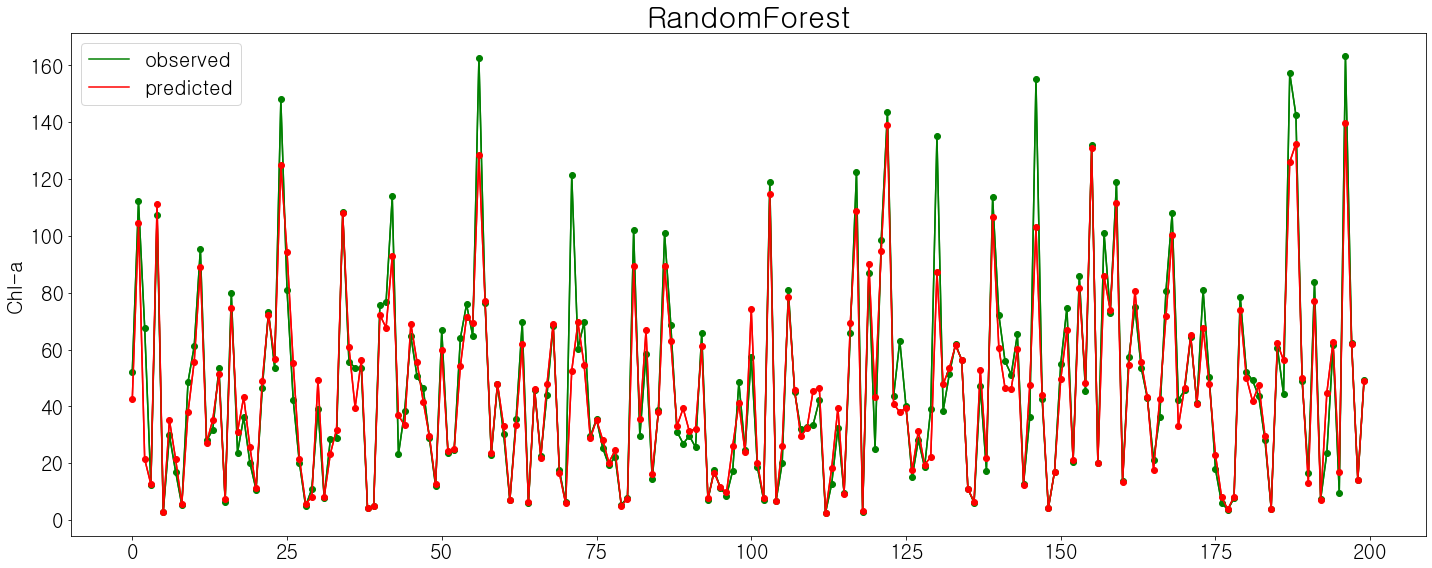

In [84]:
plt.figure(figsize=(20, 8))
plt.plot(range(200), np.expm1(y_test)[:200], color='green')
plt.plot(range(200), np.expm1(pred)[:200], color='red')
plt.plot(range(200), np.expm1(y_test)[:200], marker='o', color='green')
plt.plot(range(200), np.expm1(pred)[:200], marker='o', color='red')
plt.legend(['observed', 'predicted'], fontsize=20)
plt.ylabel('Chl-a', fontsize=20)
plt.title('RandomForest', fontsize='30')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('scb_randomForest.png', facecolor='white')
plt.show()

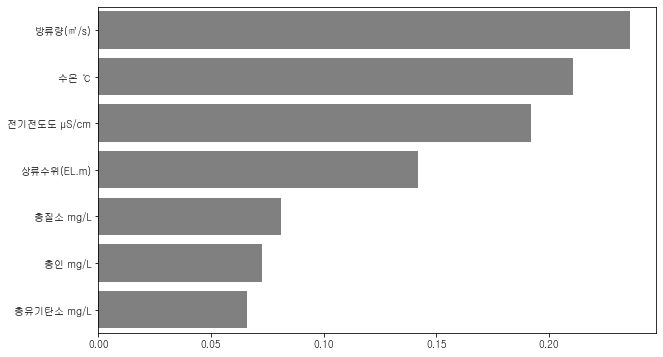

In [85]:
feature_series_rf = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_rf = feature_series_rf.sort_values(ascending = False)
sns.barplot(x = feature_series_rf[:10], y = feature_series_rf.index[:10], color = 'gray')
plt.show()

In [86]:
feature_series_rf[:10]

방류량(㎥/s)       0.235745
수온 ℃           0.210596
전기전도도 μS/cm    0.191847
상류수위(EL.m)     0.141783
총질소 mg/L       0.081172
총인 mg/L        0.072720
총유기탄소 mg/L     0.066137
dtype: float64

In [87]:
get_scores(y_test, pred)

MSE:  125.2746394115604
MSE log변환:  0.03680927927874386
RMSE:  11.192615396392409
RMSE log변환:  0.19185744520018988
R-square:  0.9530277715596561


### GradientBoosting

In [88]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15, 17, 20, 22], 'min_samples_leaf':[1, 4, 8, 12, 16]}

In [89]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [90]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END max_depth=5, min_samples_leaf=1, n_estimators=100;, score=0.763 total time=   4.4s
[CV 2/3] END max_depth=5, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   4.4s
[CV 3/3] END max_depth=5, min_samples_leaf=1, n_estimators=100;, score=0.769 total time=   4.5s
[CV 1/3] END max_depth=5, min_samples_leaf=1, n_estimators=500;, score=0.854 total time=  23.3s
[CV 2/3] END max_depth=5, min_samples_leaf=1, n_estimators=500;, score=0.861 total time=  24.2s
[CV 3/3] END max_depth=5, min_samples_leaf=1, n_estimators=500;, score=0.855 total time=  24.5s
[CV 1/3] END max_depth=5, min_samples_leaf=4, n_estimators=100;, score=0.761 total time=   4.8s
[CV 2/3] END max_depth=5, min_samples_leaf=4, n_estimators=100;, score=0.780 total time=   4.8s
[CV 3/3] END max_depth=5, min_samples_leaf=4, n_estimators=100;, score=0.770 total time=   4.8s
[CV 1/3] END max_depth=5, min_samples_leaf=4, n_estimators=500;, score=0.8

[CV 1/3] END max_depth=15, min_samples_leaf=16, n_estimators=100;, score=0.925 total time=  13.7s
[CV 2/3] END max_depth=15, min_samples_leaf=16, n_estimators=100;, score=0.926 total time=  13.8s
[CV 3/3] END max_depth=15, min_samples_leaf=16, n_estimators=100;, score=0.926 total time=  13.8s
[CV 1/3] END max_depth=15, min_samples_leaf=16, n_estimators=500;, score=0.936 total time=67.7min
[CV 2/3] END max_depth=15, min_samples_leaf=16, n_estimators=500;, score=0.935 total time= 1.2min
[CV 3/3] END max_depth=15, min_samples_leaf=16, n_estimators=500;, score=0.935 total time= 1.2min
[CV 1/3] END max_depth=17, min_samples_leaf=1, n_estimators=100;, score=0.914 total time=  16.1s
[CV 2/3] END max_depth=17, min_samples_leaf=1, n_estimators=100;, score=0.914 total time=  15.9s
[CV 3/3] END max_depth=17, min_samples_leaf=1, n_estimators=100;, score=0.912 total time=  16.2s
[CV 1/3] END max_depth=17, min_samples_leaf=1, n_estimators=500;, score=0.914 total time= 1.4min
[CV 2/3] END max_depth=1

[CV 2/3] END max_depth=22, min_samples_leaf=12, n_estimators=100;, score=0.935 total time=  17.5s
[CV 3/3] END max_depth=22, min_samples_leaf=12, n_estimators=100;, score=0.935 total time=  17.7s
[CV 1/3] END max_depth=22, min_samples_leaf=12, n_estimators=500;, score=0.939 total time= 1.9min
[CV 2/3] END max_depth=22, min_samples_leaf=12, n_estimators=500;, score=0.939 total time= 2.0min
[CV 3/3] END max_depth=22, min_samples_leaf=12, n_estimators=500;, score=0.939 total time= 2.1min
[CV 1/3] END max_depth=22, min_samples_leaf=16, n_estimators=100;, score=0.932 total time=  20.2s
[CV 2/3] END max_depth=22, min_samples_leaf=16, n_estimators=100;, score=0.931 total time=  18.4s
[CV 3/3] END max_depth=22, min_samples_leaf=16, n_estimators=100;, score=0.932 total time=  17.7s
[CV 1/3] END max_depth=22, min_samples_leaf=16, n_estimators=500;, score=0.940 total time= 1.7min
[CV 2/3] END max_depth=22, min_samples_leaf=16, n_estimators=500;, score=0.938 total time= 1.8min
[CV 3/3] END max_dep

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 15, 17, 20, 22],
                         'min_samples_leaf': [1, 4, 8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [91]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [92]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
59,"{'max_depth': 22, 'min_samples_leaf': 16, 'n_e...",0.938985,1
57,"{'max_depth': 22, 'min_samples_leaf': 12, 'n_e...",0.938904,2
55,"{'max_depth': 22, 'min_samples_leaf': 8, 'n_es...",0.938631,3
35,"{'max_depth': 17, 'min_samples_leaf': 8, 'n_es...",0.938334,4
45,"{'max_depth': 20, 'min_samples_leaf': 8, 'n_es...",0.938297,5


In [93]:
gb_grid.best_params_

{'max_depth': 22, 'min_samples_leaf': 16, 'n_estimators': 500}

In [94]:
estimator = gb_grid.best_estimator_

**베스트모델 저장**

In [95]:
joblib.dump(estimator, "승촌보_gb_전체0110.pkl")

['승촌보_gb_전체0110.pkl']

**베스트모델 다시 불러오기**

In [96]:
estimator = joblib.load("승촌보_gb_전체0110.pkl")

In [97]:
pred = estimator.predict(X_test)

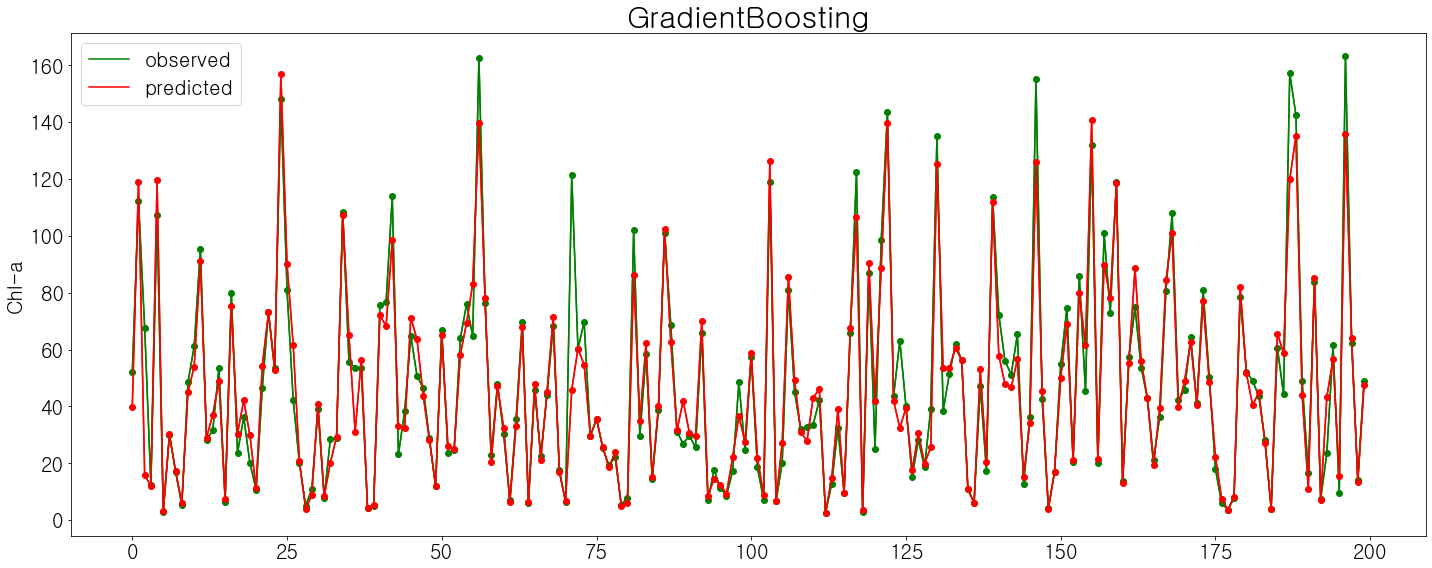

In [98]:
plt.figure(figsize=(20, 8))
plt.plot(range(200), np.expm1(y_test)[:200], color='green')
plt.plot(range(200), np.expm1(pred)[:200], color='red')
plt.plot(range(200), np.expm1(y_test)[:200], marker='o', color='green')
plt.plot(range(200), np.expm1(pred)[:200], marker='o', color='red')
plt.legend(['observed', 'predicted'], fontsize=20)
plt.ylabel('Chl-a', fontsize=20)
plt.title('GradientBoosting', fontsize='30')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('scb_gradientBoosting.png', facecolor='white')
plt.show()

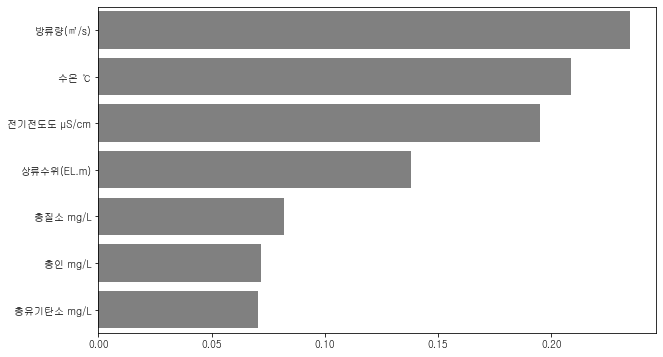

In [99]:
feature_series_gb = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_gb = feature_series_gb.sort_values(ascending = False)
sns.barplot(x = feature_series_gb[:10], y = feature_series_gb.index[:10], color = 'gray')
plt.show()

In [100]:
feature_series_gb[:10]

방류량(㎥/s)       0.234486
수온 ℃           0.208511
전기전도도 μS/cm    0.195052
상류수위(EL.m)     0.137896
총질소 mg/L       0.081912
총인 mg/L        0.071759
총유기탄소 mg/L     0.070384
dtype: float64

In [101]:
get_scores(y_test, pred)

MSE:  118.09287960344513
MSE log변환:  0.035389422000314995
RMSE:  10.867054780548644
RMSE log변환:  0.18812076440498268
R-square:  0.9548396478512291


## 특성 중요도 graph

In [122]:
importance_var = pd.concat([feature_series_dt, feature_series_rf, feature_series_gb], axis=1)
importance_var.columns = ['DT', 'RF', 'GB']
importance_var.index

Index(['방류량(㎥/s)', '수온 ℃', '전기전도도 μS/cm', '상류수위(EL.m)', '총질소 mg/L',
       '총유기탄소 mg/L', '총인 mg/L'],
      dtype='object')

In [123]:
importance_var.index = ['D-Flow (㎥/s)', 'Temp (℃)', 'EC (μS/cm)', 'WL (EL.m)', 'TN (mg/L)',
                        'TOC (mg/L)', 'TP (mg/L)']

In [124]:
importance_var

,DT,RF,GB
D-Flow (㎥/s),0.236059,0.235745,0.234486
Temp (℃),0.211421,0.210596,0.208511
EC (μS/cm),0.197957,0.191847,0.195052
WL (EL.m),0.136878,0.141783,0.137896
TN (mg/L),0.078163,0.081172,0.081912
TOC (mg/L),0.072065,0.066137,0.070384
TP (mg/L),0.067456,0.072720,0.071759


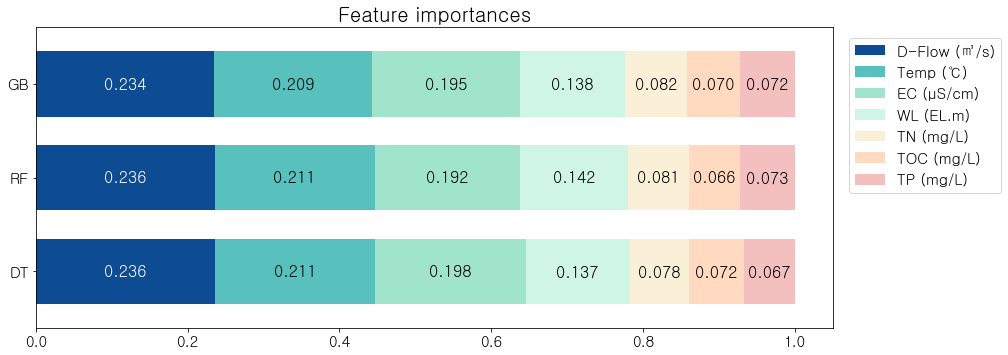

In [125]:
colors = ['#0D4C92', '#59C1BD', '#A0E4CB', '#CFF5E7', '#FAF0D7', '#FFD9C0', '#F4BFBF']

ax = importance_var.T.plot(kind='barh', stacked=True, color=colors, width=0.7, figsize=(14, 5), linewidth=0.5)

plt.title('Feature importances', fontsize=20)
plt.legend(loc = [1.02, 0.45], fontsize=15)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    colors = 'white' if (width == 0.2360590234137787 or width== 0.2357454111255473 or width==0.23448570754284773) else 'black'
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.3f}'.format(width), 
            horizontalalignment='center', 
            verticalalignment='center',
            color=colors,
            fontsize=16)
    
plt.tight_layout()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('scb_feature_importance.png', facecolor='white')
plt.show()

## 특성 산점도

In [128]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
시간,,,,,,,,,,
2013-03-29 04:00:00,용봉,13.2,296.0,3.4,5.866,0.104,75.1,7.540000,13.578333,4.332048
2013-03-29 05:00:00,용봉,13.1,296.0,3.3,5.866,0.104,73.9,7.540000,13.563333,4.316154
2013-03-29 06:00:00,용봉,12.9,296.0,3.3,5.866,0.104,72.7,7.540000,13.578333,4.300003
2013-03-29 07:00:00,용봉,12.6,294.0,3.3,5.866,0.104,66.9,7.536667,13.193333,4.218036
2013-03-29 08:00:00,용봉,12.5,292.0,3.3,5.866,0.104,63.0,7.530000,12.333333,4.158883


In [129]:
graph_scb_df = scb_df.copy()

In [130]:
graph_scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', 'log_Chl-a'],
      dtype='object')

In [131]:
graph_scb_df.columns = ['측정소명', 'Temp (℃)', 'EC (μS/cm)', 'TOC (mg/L)', 'TN (mg/L)', 'TP (mg/L)',
       '클로로필-a (mg/㎥)', 'WL (EL.m)', 'D-Flow (㎥/s)', 'Chl-a (mg/㎥)']

In [132]:
graph_scb_df.columns

Index(['측정소명', 'Temp (℃)', 'EC (μS/cm)', 'TOC (mg/L)', 'TN (mg/L)',
       'TP (mg/L)', '클로로필-a (mg/㎥)', 'WL (EL.m)', 'D-Flow (㎥/s)',
       'Chl-a (mg/㎥)'],
      dtype='object')

In [133]:
grid_col = ['Temp (℃)', 'EC (μS/cm)', 'TOC (mg/L)', 'TN (mg/L)', 'TP (mg/L)', 'WL (EL.m)', 'D-Flow (㎥/s)', 'Chl-a (mg/㎥)']
grid_scb_df = graph_scb_df.loc[:, grid_col]

In [134]:
grid_scb_df.head()

,Temp (℃),EC (μS/cm),TOC (mg/L),TN (mg/L),TP (mg/L),WL (EL.m),D-Flow (㎥/s),Chl-a (mg/㎥)
시간,,,,,,,,
2013-03-29 04:00:00,13.2,296.0,3.4,5.866,0.104,7.540000,13.578333,4.332048
2013-03-29 05:00:00,13.1,296.0,3.3,5.866,0.104,7.540000,13.563333,4.316154
2013-03-29 06:00:00,12.9,296.0,3.3,5.866,0.104,7.540000,13.578333,4.300003
2013-03-29 07:00:00,12.6,294.0,3.3,5.866,0.104,7.536667,13.193333,4.218036
2013-03-29 08:00:00,12.5,292.0,3.3,5.866,0.104,7.530000,12.333333,4.158883


In [135]:
grid_scb_df.corr()

,Temp (℃),EC (μS/cm),TOC (mg/L),TN (mg/L),TP (mg/L),WL (EL.m),D-Flow (㎥/s),Chl-a (mg/㎥)
Temp (℃),1.000000,-0.676288,0.064459,-0.659247,0.122301,0.091925,0.138783,0.051769
EC (μS/cm),-0.676288,1.000000,0.255067,0.773621,-0.225359,-0.163705,-0.321387,0.319047
TOC (mg/L),0.064459,0.255067,1.000000,0.285363,0.247875,-0.291496,-0.080865,0.329639
TN (mg/L),-0.659247,0.773621,0.285363,1.000000,-0.088248,-0.197895,-0.189936,0.261537
TP (mg/L),0.122301,-0.225359,0.247875,-0.088248,1.000000,-0.018631,0.163743,-0.177888
WL (EL.m),0.091925,-0.163705,-0.291496,-0.197895,-0.018631,1.000000,0.080684,-0.301701
D-Flow (㎥/s),0.138783,-0.321387,-0.080865,-0.189936,0.163743,0.080684,1.000000,-0.245029
Chl-a (mg/㎥),0.051769,0.319047,0.329639,0.261537,-0.177888,-0.301701,-0.245029,1.000000


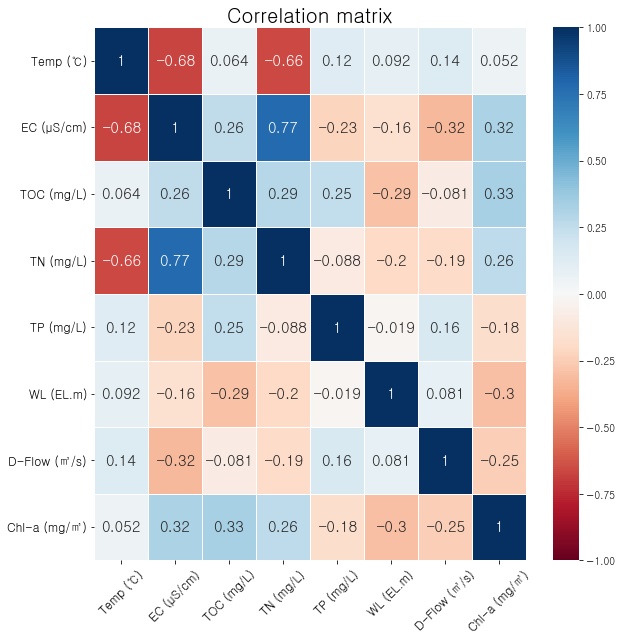

In [145]:
import seaborn as sns
plt.figure(figsize=(9,9))
corr = grid_scb_df.corr()

plt.title('Correlation matrix', fontsize=20)
sns.heatmap(corr, annot=True, cmap= 'RdBu', vmin = -1.0, annot_kws={'fontsize':15}, linewidths=.5)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=45)

plt.tight_layout()
plt.savefig('scb_heatmap.png', facecolor='white')
plt.show()

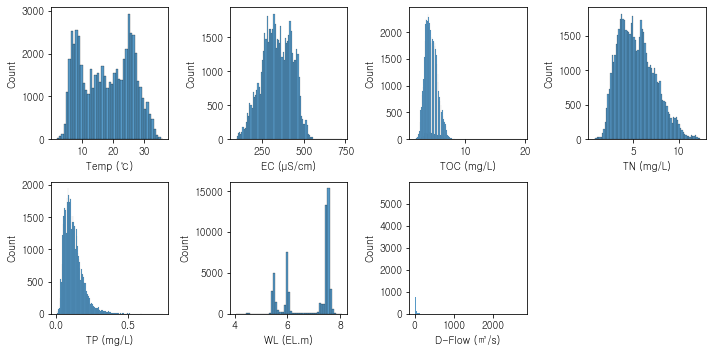

In [148]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 4, 1)
sns.histplot(graph_scb_df['Temp (℃)'])
plt.subplot(2, 4, 2)
sns.histplot(graph_scb_df['EC (μS/cm)'])
plt.subplot(2, 4, 3)
sns.histplot(graph_scb_df['TOC (mg/L)'])
plt.subplot(2, 4, 4)
sns.histplot(graph_scb_df['TN (mg/L)'])
plt.subplot(2, 4, 5)
sns.histplot(graph_scb_df['TP (mg/L)'])
plt.subplot(2, 4, 6)
sns.histplot(graph_scb_df['WL (EL.m)'])
plt.subplot(2, 4, 7)
sns.histplot(graph_scb_df['D-Flow (㎥/s)'])

plt.subplots_adjust(top=1.2, wspace=0.8)
plt.tight_layout()
plt.savefig('all_variables.png', dpi=1000, facecolor='white')
plt.show()

# 계절데이터

In [149]:
scb_season = scb_df.copy()

### 계절나누기

입춘, 입하, 입추, 입동

In [151]:
season = ['2013-02-04 00:00:00', '2013-05-05 00:00:00', '2013-08-07 00:00:00', '2013-11-07 00:00:00',
           '2014-02-04 00:00:00', '2014-05-05 00:00:00', '2014-08-07 00:00:00', '2014-11-07 00:00:00',
           '2015-02-04 00:00:00', '2015-05-06 00:00:00', '2015-08-08 00:00:00', '2015-11-08 00:00:00',
           '2016-02-04 00:00:00', '2016-05-05 00:00:00', '2016-08-07 00:00:00', '2016-11-07 00:00:00',
           '2017-02-04 00:00:00', '2017-05-05 00:00:00', '2017-08-07 00:00:00', '2017-11-07 00:00:00',
           '2018-02-04 00:00:00', '2018-05-05 00:00:00', '2018-08-07 00:00:00', '2018-11-07 00:00:00',
           '2019-02-04 00:00:00', '2019-05-06 00:00:00', '2019-08-08 00:00:00', '2019-11-08 00:00:00',
           '2020-02-04 00:00:00', '2020-05-05 00:00:00', '2020-08-07 00:00:00', '2020-11-07 00:00:00',
           '2021-02-03 00:00:00', '2021-05-05 00:00:00', '2021-08-07 00:00:00', '2021-11-07 00:00:00',
           '2022-02-04 00:00:00', '2022-05-05 00:00:00', '2022-08-07 00:00:00', '2022-11-07 00:00:00']

season_bins = np.array(season).astype('datetime64')

In [152]:
season_label = ['spring', 'summer', 'fall', 'winter'] * 10
season_label = season_label[:-1]

In [153]:
scb_season['season'] = pd.cut(scb_season.index, bins=season_bins, right=False, include_lowest=True, labels=season_label, ordered = False)

In [154]:
scb_spring = scb_season[scb_season.season == 'spring']
scb_summer = scb_season[scb_season.season == 'summer']
scb_fall = scb_season[scb_season.season == 'fall']
scb_winter = scb_season[scb_season.season == 'winter']

In [156]:
# 훈련 특성 및 target
col

['수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

### 계절별 기초통계량

In [164]:
scb_spring.describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
count,15078.000000,15078.000000,15078.000000,15078.000000,15078.000000,15078.000000,15078.000000,15078.000000,15078.000000
mean,13.130579,384.855239,4.759973,7.102997,0.124514,60.480543,6.609929,17.799245,3.862592
std,4.351168,74.319097,0.991515,1.763050,0.061150,38.689027,0.826229,21.224701,0.797592
min,4.100000,162.000000,1.800000,2.755000,0.003000,2.500000,4.038333,0.000000,1.252763
25%,9.400000,336.000000,4.042500,5.879000,0.085000,29.900000,5.971667,9.587083,3.430756
50%,13.000000,391.750000,4.700000,7.077000,0.110000,53.400000,6.080000,13.000000,3.996364
75%,16.400000,438.000000,5.333333,8.215000,0.151000,88.600000,7.498333,19.536250,4.495355
max,24.600000,561.000000,8.800000,12.357000,0.571000,243.400000,7.875000,434.091667,5.498806


In [165]:
scb_summer.describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
count,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000,13714.000000
mean,25.997599,291.628733,4.868601,4.446853,0.136501,50.710046,6.959708,36.535861,3.658757
std,3.138744,72.767708,1.036325,1.337657,0.072286,39.053591,0.885909,102.272663,0.812735
min,17.700000,96.000000,2.400000,1.417000,0.005000,1.700000,5.073333,0.000000,0.993252
25%,23.800000,250.000000,4.200000,3.486000,0.085000,23.600000,5.935000,13.580000,3.198673
50%,25.900000,287.000000,4.900000,4.227300,0.122115,40.100000,7.503333,20.102500,3.713572
75%,28.140476,326.000000,5.500000,5.308750,0.173000,68.400000,7.550000,31.132083,4.238302
max,35.600000,508.000000,19.300000,8.990000,0.745000,453.500000,8.071667,2710.731667,6.119198


In [166]:
scb_fall.describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
count,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000,15575.000000
mean,23.861017,278.196420,3.865132,3.804956,0.109607,45.827443,6.882119,35.885192,3.528120
std,4.408843,68.613819,0.753952,1.135005,0.054696,32.479642,0.942643,68.252469,0.893737
min,13.600000,92.000000,1.700000,0.706000,0.003000,1.600000,5.278333,0.000000,0.955511
25%,20.300000,232.000000,3.400000,2.946667,0.064000,18.400000,5.570000,13.420000,2.965273
50%,24.400000,281.000000,3.800000,3.687000,0.104000,40.600000,7.510000,20.653333,3.728100
75%,26.600000,329.000000,4.287967,4.574000,0.144000,67.800000,7.556667,31.637500,4.230476
max,36.100000,455.000000,8.500000,7.777000,0.343000,233.400000,7.918333,1360.893333,5.457029


In [168]:
scb_winter.describe()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
count,14689.000000,14689.000000,14689.000000,14689.000000,14689.000000,14689.000000,14689.000000,14689.000000,14689.000000
mean,9.159166,403.085384,4.016060,6.223456,0.108163,44.404837,6.944414,16.153494,3.410410
std,3.326963,58.233949,0.914778,1.636578,0.064075,36.513530,0.740424,13.104682,0.989466
min,1.800000,151.000000,1.600000,1.935000,0.025000,1.000000,5.393333,0.000000,0.693147
25%,6.600000,368.000000,3.400000,5.108000,0.065000,12.800000,6.010000,10.808333,2.624669
50%,8.300000,410.000000,3.900000,6.115000,0.091778,35.400000,7.493333,13.200000,3.594569
75%,11.200000,449.000000,4.600000,7.261000,0.133000,68.100000,7.520000,18.993333,4.234107
max,18.300000,730.000000,8.400000,10.985000,0.526000,198.400000,7.893333,497.380000,5.295313


In [169]:
season_mean_df = pd.DataFrame(scb_spring.describe().T['mean'])

In [170]:
season_mean_df.columns = ['spring']

In [171]:
season_mean_df['summer'] = scb_summer.describe().T['mean']

In [172]:
season_mean_df['fall'] = scb_fall.describe().T['mean']

In [173]:
season_mean_df['winter'] = scb_winter.describe().T['mean']

In [174]:
season_mean_df

,spring,summer,fall,winter
수온 ℃,13.130579,25.997599,23.861017,9.159166
전기전도도 μS/cm,384.855239,291.628733,278.196420,403.085384
총유기탄소 mg/L,4.759973,4.868601,3.865132,4.016060
총질소 mg/L,7.102997,4.446853,3.804956,6.223456
총인 mg/L,0.124514,0.136501,0.109607,0.108163
클로로필-a mg/㎥,60.480543,50.710046,45.827443,44.404837
상류수위(EL.m),6.609929,6.959708,6.882119,6.944414
방류량(㎥/s),17.799245,36.535861,35.885192,16.153494
log_Chl-a,3.862592,3.658757,3.528120,3.410410


In [175]:
chl_df = pd.concat([scb_spring['클로로필-a mg/㎥'], scb_summer['클로로필-a mg/㎥'], scb_fall['클로로필-a mg/㎥'], scb_winter['클로로필-a mg/㎥']], axis=1)
chl_df.columns = ['spring', 'summer', 'fall', 'winter']

In [176]:
temp_df = pd.concat([scb_spring['수온 ℃'], scb_summer['수온 ℃'], scb_fall['수온 ℃'], scb_winter['수온 ℃']], axis=1)
temp_df.columns = ['spring', 'summer', 'fall', 'winter']

In [177]:
ec_df = pd.concat([scb_spring['전기전도도 μS/cm'], scb_summer['전기전도도 μS/cm'], scb_fall['전기전도도 μS/cm'], scb_winter['전기전도도 μS/cm']], axis=1)
ec_df.columns = ['spring', 'summer', 'fall', 'winter']

In [178]:
toc_df = pd.concat([scb_spring['총유기탄소 mg/L'], scb_summer['총유기탄소 mg/L'], scb_fall['총유기탄소 mg/L'], scb_winter['총유기탄소 mg/L']], axis=1)
toc_df.columns = ['spring', 'summer', 'fall', 'winter']

In [179]:
tn_df = pd.concat([scb_spring['총질소 mg/L'], scb_summer['총질소 mg/L'], scb_fall['총질소 mg/L'], scb_winter['총질소 mg/L']], axis=1)
tn_df.columns = ['spring', 'summer', 'fall', 'winter']

In [180]:
tp_df = pd.concat([scb_spring['총인 mg/L'], scb_summer['총인 mg/L'], scb_fall['총인 mg/L'], scb_winter['총인 mg/L']], axis=1)
tp_df.columns = ['spring', 'summer', 'fall', 'winter']

In [181]:
wl_df = pd.concat([scb_spring['상류수위(EL.m)'], scb_summer['상류수위(EL.m)'], scb_fall['상류수위(EL.m)'], scb_winter['상류수위(EL.m)']], axis=1)
wl_df.columns = ['spring', 'summer', 'fall', 'winter']

In [182]:
dflow_df = pd.concat([scb_spring['방류량(㎥/s)'], scb_summer['방류량(㎥/s)'], scb_fall['방류량(㎥/s)'], scb_winter['방류량(㎥/s)']], axis=1)
dflow_df.columns = ['spring', 'summer', 'fall', 'winter']

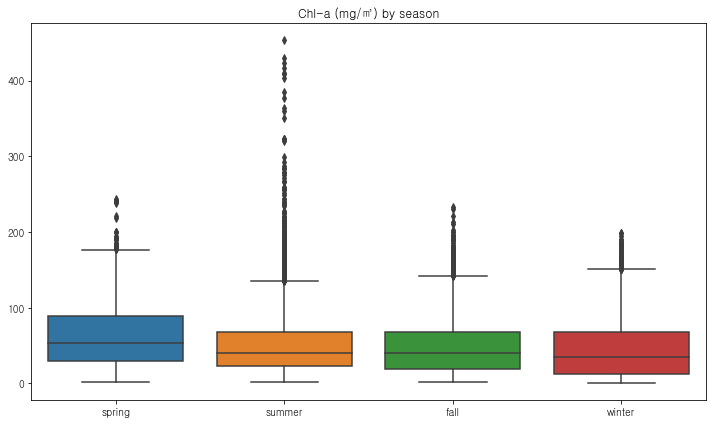

In [184]:
sns.boxplot(data = chl_df)
plt.title('Chl-a (mg/㎥) by season')
plt.tight_layout()
plt.savefig('Chl-a by season.png', facecolor='white')
plt.show()

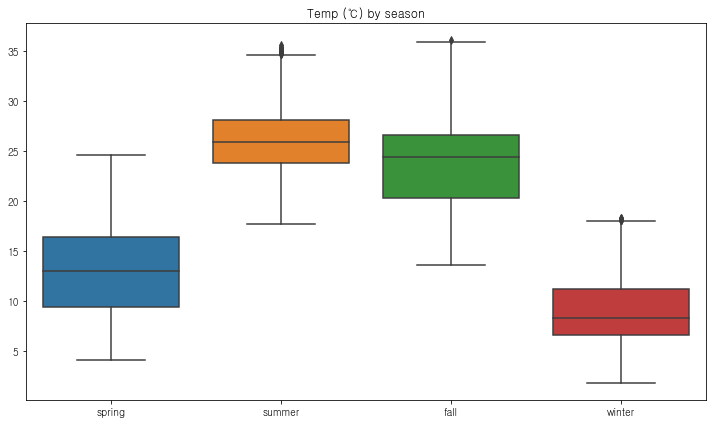

In [185]:
sns.boxplot(data = temp_df)
plt.title('Temp (℃) by season')
plt.tight_layout()
plt.savefig('Temp by season.png', facecolor='white')
plt.show()

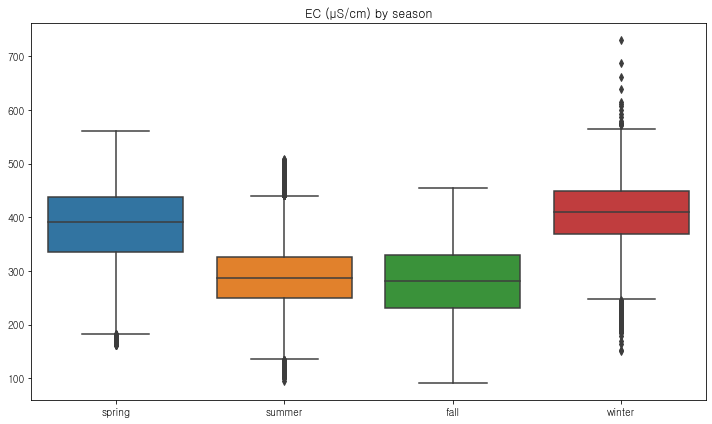

In [187]:
sns.boxplot(data = ec_df)
plt.title('EC (μS/cm) by season')
plt.tight_layout()
plt.savefig('ec by season.png', facecolor='white')
plt.show()

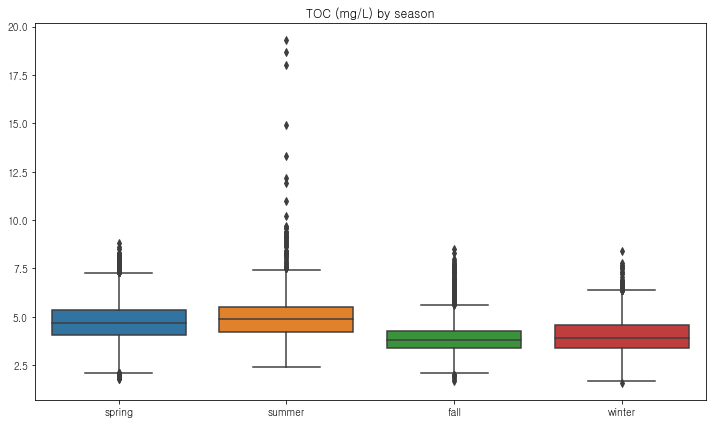

In [188]:
sns.boxplot(data = toc_df)
plt.title('TOC (mg/L) by season')
plt.tight_layout()
plt.savefig('TOC by season.png', facecolor='white')
plt.show()

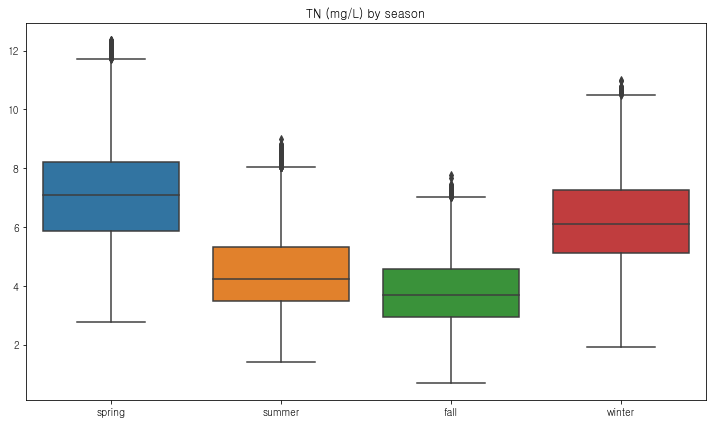

In [189]:
sns.boxplot(data = tn_df)
plt.title('TN (mg/L) by season')
plt.tight_layout()
plt.savefig('TN by season.png', facecolor='white')
plt.show()

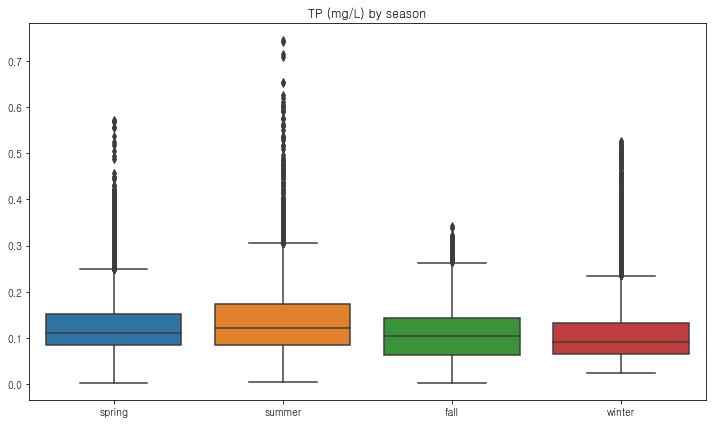

In [190]:
sns.boxplot(data = tp_df)
plt.title('TP (mg/L) by season')
plt.tight_layout()
plt.savefig('TP by season.png', facecolor='white')
plt.show()

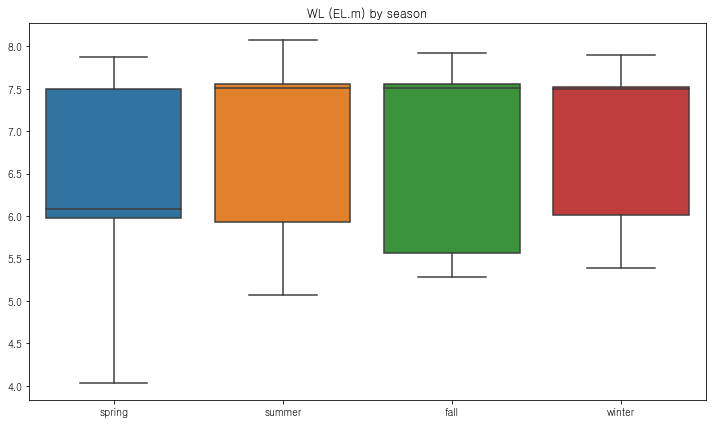

In [191]:
sns.boxplot(data = wl_df)
plt.title('WL (EL.m) by season')
plt.tight_layout()
plt.savefig('upH by season.png', facecolor='white')
plt.show()

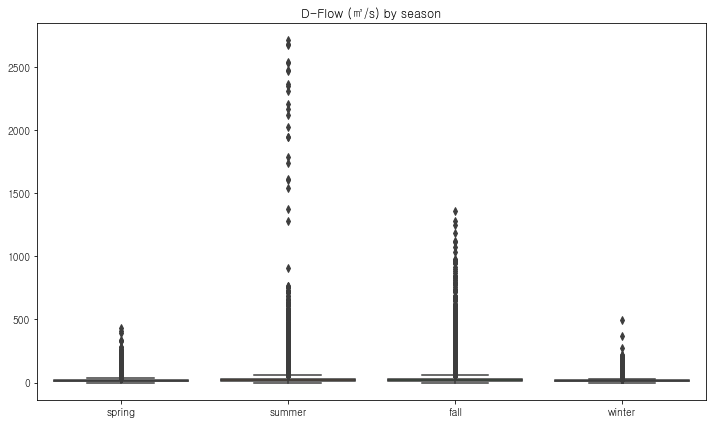

In [193]:
sns.boxplot(data = dflow_df)
plt.title('D-Flow (㎥/s) by season')
plt.tight_layout()
plt.savefig('dflow by season.png', facecolor='white')
plt.show()

## 평가

In [157]:
def get_scores(y_test, pred):
    print('MSE: ', mean_squared_error(np.expm1(y_test), np.expm1(pred)))
    print('MSE log변환: ', mean_squared_error(y_test, pred))
    print('RMSE: ', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred))))
    print('RMSE log변환: ', np.sqrt(mean_squared_error(y_test, pred)))
    print('R-square: ', estimator.score(X_test, y_test) )

## GB - spring

In [194]:
X_train, X_test, y_train, y_test = train_test_split(scb_spring.loc[:, col], scb_spring['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=22, min_samples_leaf=16)

In [195]:
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=22, min_samples_leaf=16, n_estimators=500,
                          random_state=42)

In [196]:
joblib.dump(gb_reg, "승촌보_gb_spring0110.pkl")

['승촌보_gb_spring0110.pkl']

In [197]:
estimator = joblib.load("승촌보_gb_spring0110.pkl")

In [198]:
pred = estimator.predict(X_test)

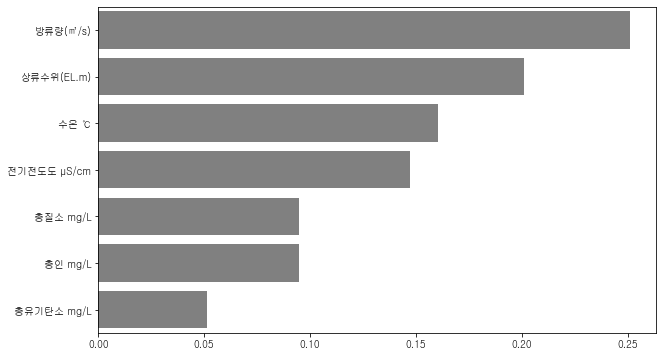

In [199]:
feature_series_spring = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_spring = feature_series_spring.sort_values(ascending = False)
sns.barplot(x = feature_series_spring[:10], y = feature_series_spring.index[:10], color = 'gray')
plt.show()

In [200]:
feature_series_spring[:10]

방류량(㎥/s)       0.250780
상류수위(EL.m)     0.200737
수온 ℃           0.160386
전기전도도 μS/cm    0.147307
총질소 mg/L       0.094688
총인 mg/L        0.094587
총유기탄소 mg/L     0.051515
dtype: float64

In [201]:
get_scores(y_test, pred)

MSE:  88.20714022071678
MSE log변환:  0.02600402361715263
RMSE:  9.391865641112886
RMSE log변환:  0.16125763119044206
R-square:  0.9590787337033624


## GB - summer

In [202]:
X_train, X_test, y_train, y_test = train_test_split(scb_summer.loc[:, col], scb_summer['log_Chl-a'], random_state=42) #변경2
gb_reg = GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=22, min_samples_leaf=16)

In [203]:
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=22, min_samples_leaf=16, n_estimators=500,
                          random_state=42)

In [204]:
joblib.dump(gb_reg, "승촌보_gb_summer0110.pkl")  #변경1

['승촌보_gb_summer0110.pkl']

In [205]:
estimator = joblib.load("승촌보_gb_summer0110.pkl") #변경1

In [206]:
pred = estimator.predict(X_test)

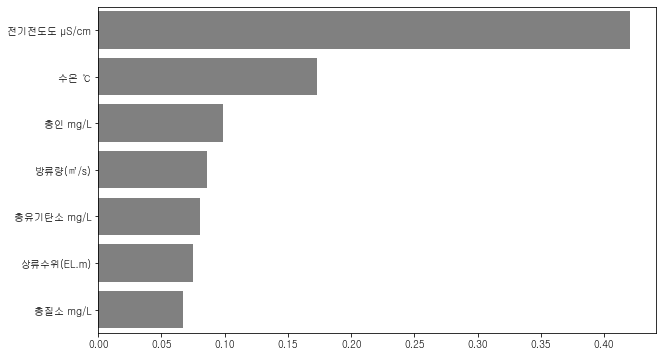

In [207]:
feature_series_summer = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_summer = feature_series_summer.sort_values(ascending = False)
sns.barplot(x = feature_series_summer[:10], y = feature_series_summer.index[:10], color = 'gray')
plt.show()

In [208]:
feature_series_summer[:10]

전기전도도 μS/cm    0.420117
수온 ℃           0.172673
총인 mg/L        0.098423
방류량(㎥/s)       0.086127
총유기탄소 mg/L     0.080274
상류수위(EL.m)     0.075309
총질소 mg/L       0.067078
dtype: float64

In [209]:
get_scores(y_test, pred)

MSE:  169.07165990994304
MSE log변환:  0.03183348151767657
RMSE:  13.002755858276469
RMSE log변환:  0.17841939781782856
R-square:  0.9524342284913642


## GB - fall

In [210]:
X_train, X_test, y_train, y_test = train_test_split(scb_fall.loc[:, col], scb_fall['log_Chl-a'], random_state=42) #변경2
gb_reg = GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=22, min_samples_leaf=16)

In [211]:
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=22, min_samples_leaf=16, n_estimators=500,
                          random_state=42)

In [212]:
joblib.dump(gb_reg, "승촌보_gb_fall0110.pkl")  #변경1

['승촌보_gb_fall0110.pkl']

In [213]:
estimator = joblib.load("승촌보_gb_fall0110.pkl") #변경1

In [214]:
pred = estimator.predict(X_test)

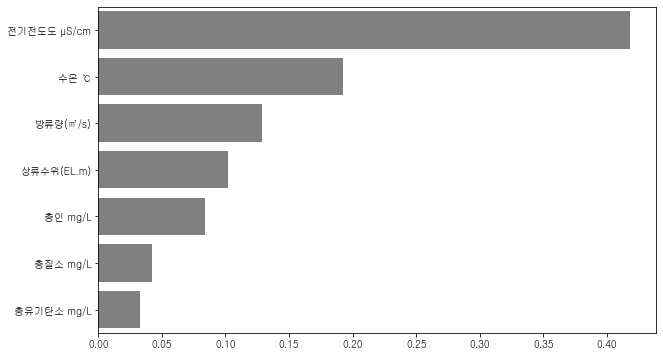

In [215]:
feature_series_fall = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_fall = feature_series_fall.sort_values(ascending = False)
sns.barplot(x = feature_series_fall[:10], y = feature_series_fall.index[:10], color = 'gray')
plt.show()

In [216]:
feature_series_fall[:10]

전기전도도 μS/cm    0.417731
수온 ℃           0.192686
방류량(㎥/s)       0.128554
상류수위(EL.m)     0.101841
총인 mg/L        0.084134
총질소 mg/L       0.042402
총유기탄소 mg/L     0.032653
dtype: float64

In [217]:
get_scores(y_test, pred)

MSE:  81.2326534427376
MSE log변환:  0.033549610083361464
RMSE:  9.012915923425536
RMSE log변환:  0.18316552645997955
R-square:  0.9580053844942985


## GB-winter

In [218]:
X_train, X_test, y_train, y_test = train_test_split(scb_winter.loc[:, col], scb_winter['log_Chl-a'], random_state=42) #변경2
gb_reg = GradientBoostingRegressor(random_state=42, n_estimators=500, max_depth=22, min_samples_leaf=16)

In [219]:
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=22, min_samples_leaf=16, n_estimators=500,
                          random_state=42)

In [221]:
joblib.dump(gb_reg, "승촌보_gb_winter0110.pkl")  #변경1

['승촌보_gb_winter0110.pkl']

In [223]:
estimator = joblib.load("승촌보_gb_winter0110.pkl") #변경1

In [224]:
pred = estimator.predict(X_test)

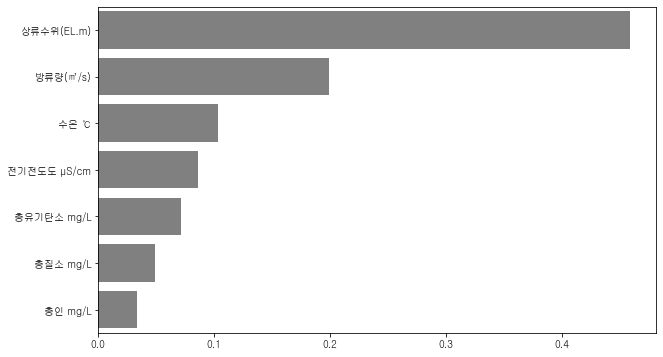

In [225]:
feature_series_winter = pd.Series(data = estimator.feature_importances_, index = col)
feature_series_winter = feature_series_winter.sort_values(ascending = False)
sns.barplot(x = feature_series_winter[:10], y = feature_series_winter.index[:10], color = 'gray')
plt.show()

In [226]:
feature_series_winter[:10]

상류수위(EL.m)     0.458407
방류량(㎥/s)       0.198974
수온 ℃           0.103478
전기전도도 μS/cm    0.085848
총유기탄소 mg/L     0.071233
총질소 mg/L       0.048686
총인 mg/L        0.033374
dtype: float64

In [227]:
get_scores(y_test, pred)

MSE:  48.0827064580838
MSE log변환:  0.022304311116212963
RMSE:  6.934169485820475
RMSE log변환:  0.14934627921783977
R-square:  0.9769373948789507


## 특성 중요도 그래프

In [228]:
feature_series_winter

상류수위(EL.m)     0.458407
방류량(㎥/s)       0.198974
수온 ℃           0.103478
전기전도도 μS/cm    0.085848
총유기탄소 mg/L     0.071233
총질소 mg/L       0.048686
총인 mg/L        0.033374
dtype: float64

In [229]:
importance_var = pd.concat([feature_series_winter, feature_series_fall, feature_series_summer, feature_series_spring], axis=1)
importance_var.columns = ['winter', 'fall', 'summer', 'spring']

importance_var.reindex(feature_series_spring.index)
#importance_var.index = ['']    #['D_Flow ㎥/s', 'Up_H EL.m', 'Temp ℃', 'EC μS/cm', 'TN mg/L',  'TP mg/L', 'TOC mg/L']

,winter,fall,summer,spring
방류량(㎥/s),0.198974,0.128554,0.086127,0.250780
상류수위(EL.m),0.458407,0.101841,0.075309,0.200737
수온 ℃,0.103478,0.192686,0.172673,0.160386
전기전도도 μS/cm,0.085848,0.417731,0.420117,0.147307
총질소 mg/L,0.048686,0.042402,0.067078,0.094688
총인 mg/L,0.033374,0.084134,0.098423,0.094587
총유기탄소 mg/L,0.071233,0.032653,0.080274,0.051515


In [230]:
importance_var = importance_var.reindex(feature_series_spring.index)
importance_var.index = ['D-Flow (㎥/s)', 'WL (EL.m)', 'Temp (℃)', 'EC (μS/cm)', 'TN (mg/L)',  'TP (mg/L)', 'TOC (mg/L)']

In [231]:
importance_var

,winter,fall,summer,spring
D-Flow (㎥/s),0.198974,0.128554,0.086127,0.250780
WL (EL.m),0.458407,0.101841,0.075309,0.200737
Temp (℃),0.103478,0.192686,0.172673,0.160386
EC (μS/cm),0.085848,0.417731,0.420117,0.147307
TN (mg/L),0.048686,0.042402,0.067078,0.094688
TP (mg/L),0.033374,0.084134,0.098423,0.094587
TOC (mg/L),0.071233,0.032653,0.080274,0.051515


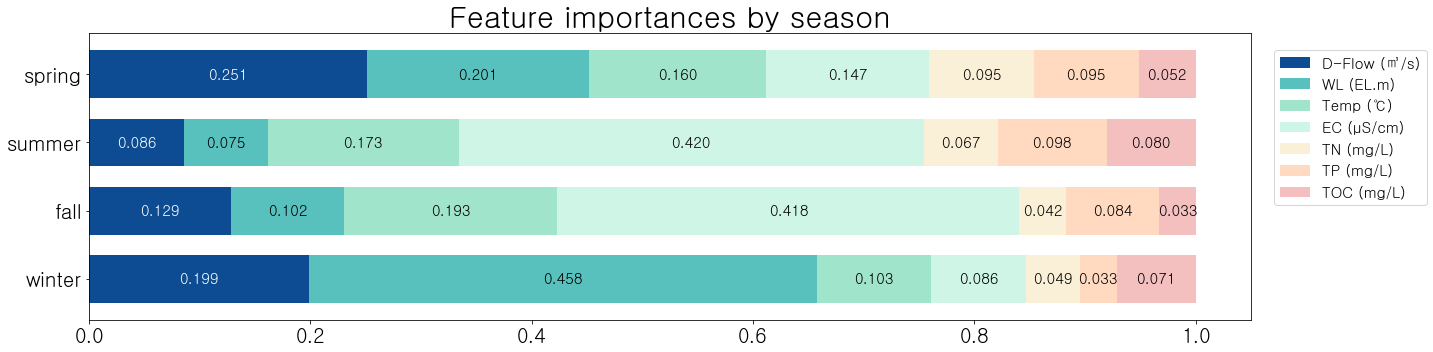

In [244]:
colors = ['#0D4C92', '#59C1BD', '#A0E4CB', '#CFF5E7', '#FAF0D7', '#FFD9C0', '#F4BFBF']

ax = importance_var.T.plot(kind='barh', stacked=True, color=colors, width=0.7, figsize=(20, 5), linewidth=0.5)

plt.title('Feature importances by season', fontsize=30)
plt.legend(loc = [1.02, 0.4], fontsize=15)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    colors = 'white' if (width == 0.19897414198576072 or width== 0.12855387552342065 or width==0.08612679639626296 or width==0.2507800661950158) else 'black'
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.3f}'.format(width), 
            horizontalalignment='center', 
            verticalalignment='center',
            color=colors,
            fontsize=15)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('scb_feature_importance_season.png', facecolor='white')
plt.show()